In [22]:
import pandas as pd
import geopandas as gpd
from sklearn.metrics import precision_score, recall_score,mean_squared_error,r2_score,confusion_matrix
from scipy import stats
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [64]:
pred = pd.read_csv("../data/weser_aue/run5/classification_results.csv")

## Analyse predictions

How many front and back shots have the same prediction?

In [65]:
(pred.groupby("img_id").nunique().type_pred == 1).sum() / len(pred.img_id.unique())

0.6370757180156658

82% have a same type prediction for front and back.

In [66]:
same_type_ids = (pred.groupby("img_id").nunique().type_pred == 1).index.values

In [67]:
same_type_pred = pred[pred.img_id.isin(same_type_ids)]
(same_type_pred.groupby(["img_id", "type_pred"]).nunique().quality_pred == 1).sum() / len(same_type_ids)

0.7258485639686684

35 % have the same quality when same type is predicted.

In [51]:
# TODO
# osm = pd.read_csv("../data/weser_aue/run2/osm_metadata.csv")
#df = pred.join(osm.set_index("image_id"), on="image_id")

## Road segment evaluation

In [3]:
validation_way_ids = pd.read_csv("/Users/alexandra/Documents/GitHub/road_network_classification/data/weser_aue/validation_way_ids.csv").ID.values

In [4]:
gt = pd.read_csv("/Users/alexandra/Documents/GitHub/road_network_classification/data/weser_aue/weser_aue_ground_truth.csv")
gt = gt[["ID","type_ground_truth", "quality_ground_truth",  "checked"]]
pred = pd.read_csv("/Users/alexandra/Documents/GitHub/road_network_classification/data/weser_aue/run4/weser_aue_ways_pred.csv")
#pred = gpd.read_file("/Users/alexandra/Documents/GitHub/road_network_classification/data/weser_aue/weser_aue_ways_pred.shp")
#pred = pred[["id", "geom", "type_pred", "avg_class_prob", "avg_quality_pred"]]
pred = pred[["ID", "TYPE_PRED", "AVG_CLASS_", "AVG_QUALIT"]]
pred.rename(columns={"ID":"id", "TYPE_PRED": "type_pred", "AVG_CLASS_": "avg_class_prob", "AVG_QUALIT": "avg_quality_pred"}, inplace=True)
pred

,id,type_pred,avg_class_prob,avg_quality_pred
0,5028869,NaN,NaN,NaN
1,5028875,NaN,NaN,NaN
2,5032195,NaN,NaN,NaN
3,5032199,NaN,NaN,NaN
4,5032783,NaN,NaN,NaN
...,...,...,...,...
11512,1212736843,asphalt,0.895908,1.688496
11513,1213820555,unpaved,0.923292,4.072248
11514,1213857950,asphalt,0.601255,3.234885
11515,1213625031,NaN,NaN,1.524380


In [5]:
df = gt.set_index("ID").join(pred.set_index("id"))
df = df[df.type_pred.notna()]
df = df[df.type_ground_truth.notna()]


In [6]:
df["quality_ground_truth_float"] = df.quality_ground_truth.map({"excellent": 1, "good": 2, "intermediate": 3, "bad": 4, "very_bad": 5})

In [7]:
(df.type_pred == df.type_ground_truth).sum() / len(df)

0.852411388727484

In [8]:
checked = df[df.checked == 1]
(checked.type_pred == checked.type_ground_truth).sum() / len(checked)

0.7594339622641509

In [9]:
validation = df[df.index.isin(validation_way_ids)]
(validation.type_pred == validation.type_ground_truth).sum() / len(validation)

0.8380414312617702

In [10]:
checked.groupby("type_ground_truth").size()

type_ground_truth
asphalt          104
concrete           7
paving_stones     68
sett              15
unpaved           18
dtype: int64

#### Confusion matrix surface types

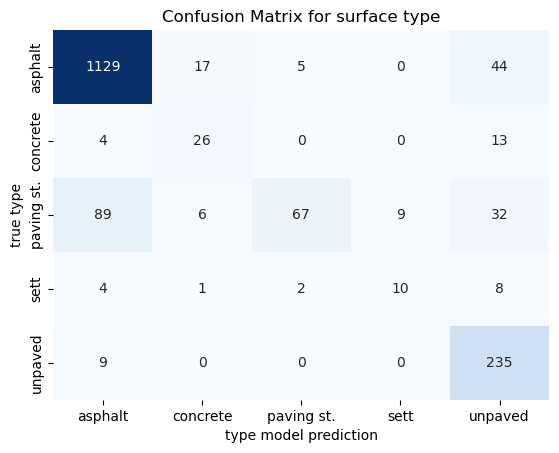

In [11]:
cm = confusion_matrix(df.type_ground_truth, df.type_pred, labels=["asphalt", "concrete", "paving_stones", "sett", "unpaved"])
plt.figure()
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["asphalt", "concrete", "paving st.", "sett", "unpaved"],
            yticklabels=["asphalt", "concrete", "paving st.", "sett", "unpaved"])
plt.title(f"Confusion Matrix for surface type")
plt.xlabel("type model prediction")
plt.ylabel("true type")
plt.savefig("confusion_matrix_type_run10.png", transparent=True, bbox_inches='tight')
plt.show()

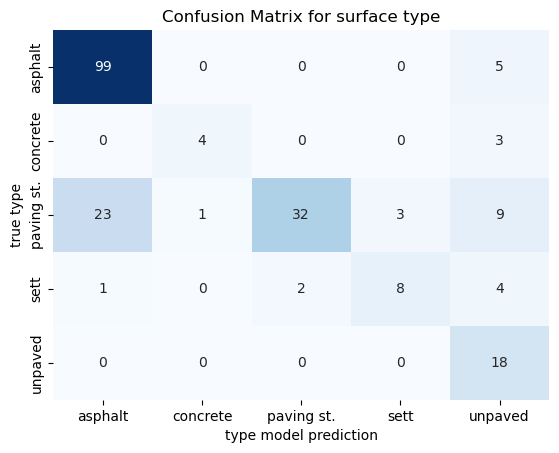

In [12]:
cm = confusion_matrix(checked.type_ground_truth, checked.type_pred, labels=["asphalt", "concrete", "paving_stones", "sett", "unpaved"])
plt.figure()
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["asphalt", "concrete", "paving st.", "sett", "unpaved"],
            yticklabels=["asphalt", "concrete", "paving st.", "sett", "unpaved"])
plt.title(f"Confusion Matrix for surface type")
plt.xlabel("type model prediction")
plt.ylabel("true type")
plt.show()

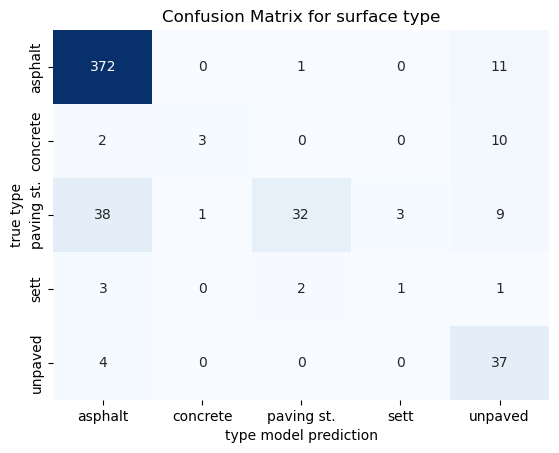

In [13]:
cm = confusion_matrix(validation.type_ground_truth, validation.type_pred, labels=["asphalt", "concrete", "paving_stones", "sett", "unpaved"])
plt.figure()
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["asphalt", "concrete", "paving st.", "sett", "unpaved"],
            yticklabels=["asphalt", "concrete", "paving st.", "sett", "unpaved"])
plt.title(f"Confusion Matrix for surface type")
plt.xlabel("type model prediction")
plt.ylabel("true type")
plt.savefig("confusion_matrix_type_run10.png", transparent=True, bbox_inches='tight')
plt.show()

In [15]:
# Extract predicted and ground truth values
for class_name in df['type_ground_truth'].unique():
    if class_name == "not in categories":
        continue
    _df1 = df[df['type_pred'] == class_name]
    _df2 = df[df['type_ground_truth'] == class_name]
    class_precision = sum(_df1.type_ground_truth == class_name) / len(_df1)
    class_recall = sum(_df2.type_pred == class_name) / len(_df2)

    print(f"Class: {class_name}")
    print(f"Count (pred): {len(_df1)}")
    print(f"Count (true): {len(_df2)}")
    print(f"Precision: {round(class_precision, 2)}")
    print(f"Recall: {round(class_recall, 2)}")
    print("------------------------")

Class: asphalt
Count (pred): 1237
Count (true): 1195
Precision: 0.91
Recall: 0.94
------------------------
Class: unpaved
Count (pred): 341
Count (true): 244
Precision: 0.69
Recall: 0.96
------------------------
Class: concrete
Count (pred): 50
Count (true): 43
Precision: 0.52
Recall: 0.6
------------------------
Class: paving_stones
Count (pred): 74
Count (true): 203
Precision: 0.91
Recall: 0.33
------------------------
Class: sett
Count (pred): 19
Count (true): 25
Precision: 0.53
Recall: 0.4
------------------------


#### Quality

In [45]:
def quality_to_class(quality_float):
    if quality_float < 1.5:
        return "excellent"
    elif quality_float < 2.5:
        return "good"
    elif quality_float < 3.5:
        return "intermediate"
    elif quality_float < 4.5:
        return "bad"
    elif quality_float < 5.5:
        return "very_bad"
    else:
        return None
    
def quality_to_float(quality):
    if quality == "excellent":
        return 1
    elif quality == "good":
        return 2
    elif quality == "intermediate":
        return 3
    elif quality == "bad":
        return 4
    elif quality == "very_bad":
        return 5
    else:
        return None
    
df["quality_pred"] = df.avg_quality_pred.apply(quality_to_class)

In [46]:
df.loc[df.avg_quality_pred > 5.5, "avg_quality_pred"] = None # exclude everything below very bad

In [47]:
df["deviation"] = df.quality_ground_truth_float - df.avg_quality_pred
df.deviation.describe()

count    1363.000000
mean        0.085437
std         0.632416
min        -2.623649
25%        -0.342983
50%         0.073042
75%         0.475665
max         2.258042
Name: deviation, dtype: float64

<Axes: >

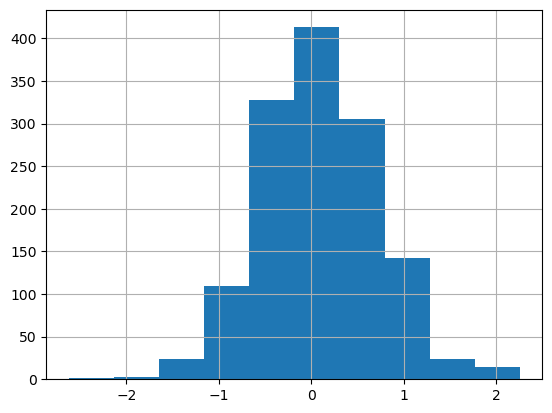

In [48]:
df.deviation.hist()

In [49]:
valid_qualities = df[df.quality_ground_truth_float.notna()]
valid_qualities = valid_qualities[valid_qualities.avg_quality_pred.notna()]
mean_squared_error(valid_qualities.quality_ground_truth_float, valid_qualities.avg_quality_pred)

0.40695584079592867

In [50]:
valid_qualities_checked = valid_qualities[valid_qualities.checked == 1]
mean_squared_error(valid_qualities_checked.quality_ground_truth_float, valid_qualities_checked.avg_quality_pred)

0.3125597867280908

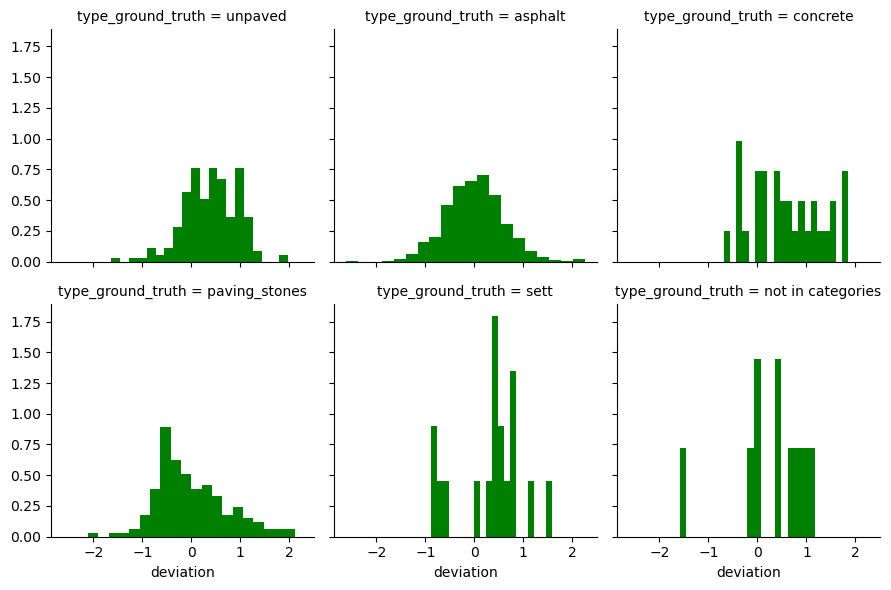

In [51]:
# Create a FacetGrid for histograms
g_hist = sns.FacetGrid(valid_qualities, col="type_ground_truth", col_wrap=3)

# Map histogram for a deviation for each surface type
g_hist.map(plt.hist, "deviation", color='green', density=True, bins=20)

plt.show()

# positive deviation means that the quality is overestimated

In [52]:
for class_name in df['type_ground_truth'].unique():
    if class_name == "not in categories":
        continue
    _df1 = valid_qualities[valid_qualities['type_pred'] == class_name]
    mse = mean_squared_error(_df1.quality_ground_truth_float, _df1.avg_quality_pred)

    print(f"Class: {class_name}")
    print(f"Count (true): {len(_df1)}")
    print(f"MSE: {round(mse, 2)}")
    print("------------------------")

Class: asphalt
Count (true): 977
MSE: 0.37
------------------------
Class: unpaved
Count (true): 279
MSE: 0.49
------------------------
Class: concrete
Count (true): 36
MSE: 0.91
------------------------
Class: paving_stones
Count (true): 56
MSE: 0.3
------------------------
Class: sett
Count (true): 15
MSE: 0.53
------------------------


##### Confusion matrices

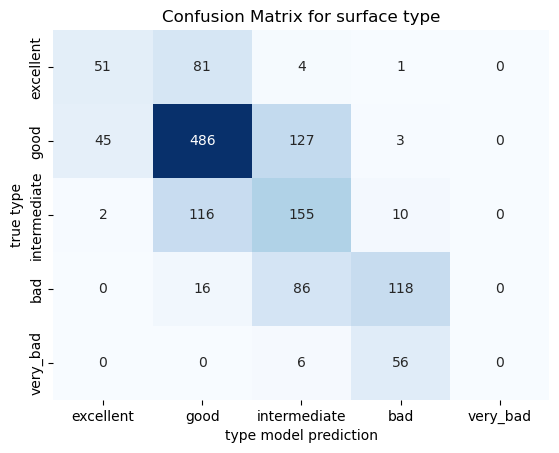

In [53]:
cm = confusion_matrix(valid_qualities.quality_ground_truth, valid_qualities.quality_pred, labels=["excellent", "good", "intermediate", "bad", "very_bad"])
plt.figure()
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["excellent", "good", "intermediate", "bad", "very_bad"],
            yticklabels=["excellent", "good", "intermediate", "bad", "very_bad"])
plt.title(f"Confusion Matrix for surface type")
plt.xlabel("type model prediction")
plt.ylabel("true type")
plt.show()

In [35]:
stats.spearmanr(valid_qualities.quality_ground_truth_float, valid_qualities.avg_quality_pred)

SignificanceResult(statistic=0.7371884114112426, pvalue=5.636466547968969e-234)

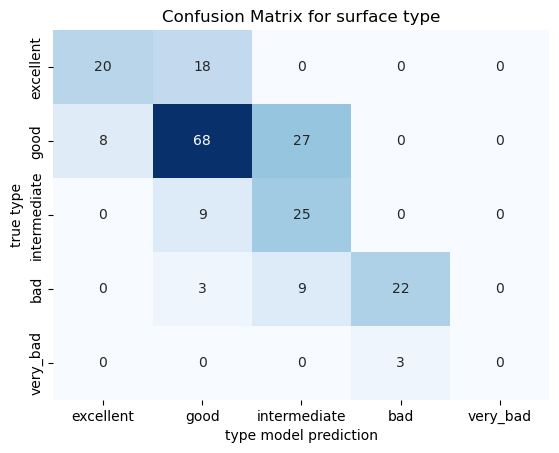

In [54]:
cm = confusion_matrix(valid_qualities_checked.quality_ground_truth, valid_qualities_checked.quality_pred, labels=["excellent", "good", "intermediate", "bad", "very_bad"])
plt.figure()
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["excellent", "good", "intermediate", "bad", "very_bad"],
            yticklabels=["excellent", "good", "intermediate", "bad", "very_bad"])
plt.title(f"Confusion Matrix for surface type")
plt.xlabel("type model prediction")
plt.ylabel("true type")
plt.show()

In [55]:
stats.spearmanr(valid_qualities_checked.quality_ground_truth_float, valid_qualities_checked.avg_quality_pred)

SignificanceResult(statistic=0.7931339661758975, pvalue=4.1349399945287495e-47)

## Analyze original images

In [25]:
orig = pd.read_csv("/Users/alexandra/Documents/GitHub/road_network_classification/data/weser_aue/run5/classification_results.csv")
small = pd.read_csv("/Users/alexandra/Documents/GitHub/road_network_classification/data/weser_aue/run3/classification_results.csv")
gt = pd.read_csv("/Users/alexandra/Documents/GitHub/road_network_classification/data/weser_aue/weser_aue_ground_truth.csv")
link = pd.read_csv("/Users/alexandra/Documents/GitHub/road_network_classification/data/weser_aue/run5/weser_aue_points_pred.csv")

In [26]:
gt = gt[["ID", "type_ground_truth", "quality_ground_truth"]]

In [4]:
merged = orig.set_index(["img_id", "direction"]).join(small.set_index(["img_id", "direction"]), lsuffix="_orig", rsuffix="_2048", how="inner")
merged.reset_index(inplace=True)
merged = merged.set_index("img_id").join(link[["IMG_ID", "WAY_ID"]].set_index("IMG_ID"))
merged.reset_index(inplace=True)
merged = merged.set_index("WAY_ID").join(gt.set_index("ID"))

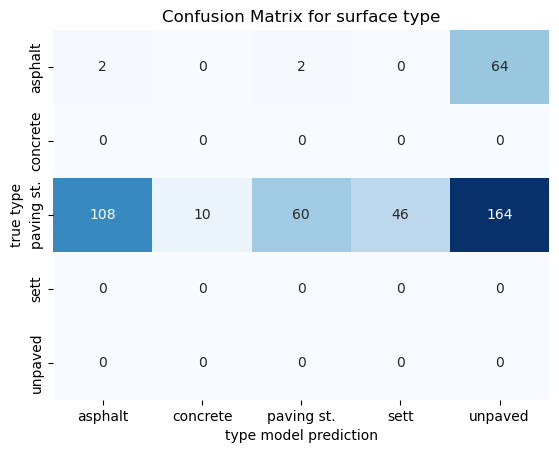

In [463]:
cm = confusion_matrix(merged.type_ground_truth, merged.type_pred_2048, labels=["asphalt", "concrete", "paving_stones", "sett", "unpaved"])
plt.figure()
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["asphalt", "concrete", "paving st.", "sett", "unpaved"],
            yticklabels=["asphalt", "concrete", "paving st.", "sett", "unpaved"])
plt.title(f"Confusion Matrix for surface type")
plt.xlabel("type model prediction")
plt.ylabel("true type")
plt.show()

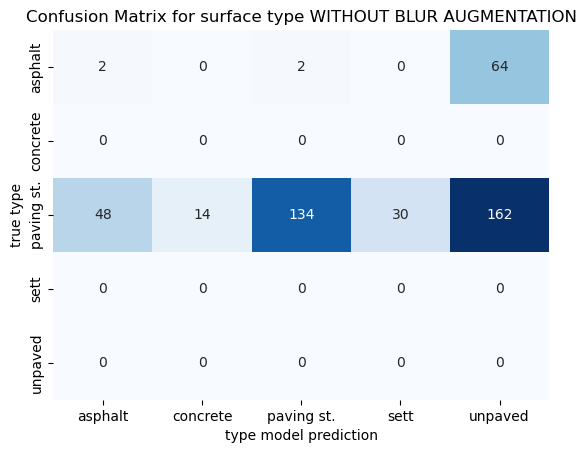

In [464]:
cm = confusion_matrix(merged.type_ground_truth, merged.type_pred_orig, labels=["asphalt", "concrete", "paving_stones", "sett", "unpaved"])
plt.figure()
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["asphalt", "concrete", "paving st.", "sett", "unpaved"],
            yticklabels=["asphalt", "concrete", "paving st.", "sett", "unpaved"])
plt.title(f"Confusion Matrix for surface type WITHOUT BLUR AUGMENTATION")
plt.xlabel("type model prediction")
plt.ylabel("true type")
plt.savefig("confusion_matrix_type_v1_0.png", transparent=True, bbox_inches='tight')
plt.show()

In [467]:
(merged.type_ground_truth == merged.type_pred_2048).sum() / len(merged)

0.13596491228070176

In [468]:
(merged.type_ground_truth == merged.type_pred_orig).sum() / len(merged)

0.2982456140350877

### Compare original with and without blurr augmentation

In [425]:
origBlur = pd.read_csv("/Users/alexandra/Documents/GitHub/road_network_classification/data/weser_aue/run8/classification_results.csv")

In [426]:
merged = (orig.set_index(["img_id", "direction"]).join(origBlur.set_index(["img_id", "direction"]), lsuffix="_orig", rsuffix="_Blur", how="inner")
)
merged.reset_index(inplace=True)
merged = merged.set_index("img_id").join(link[["IMG_ID", "WAY_ID"]].set_index("IMG_ID"))
merged.reset_index(inplace=True)
merged = merged.set_index("WAY_ID").join(gt.set_index("ID"))

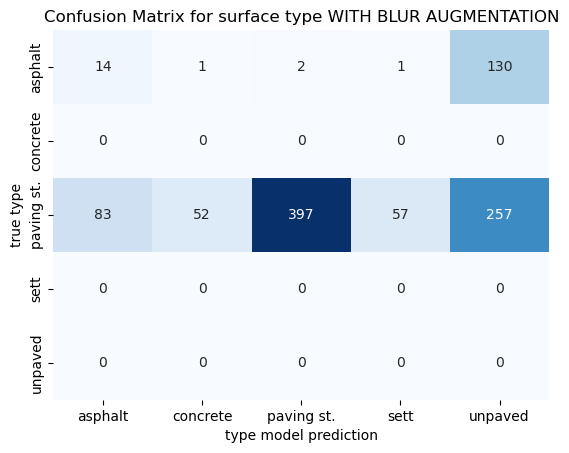

In [428]:
cm = confusion_matrix(merged.type_ground_truth, merged.type_pred_Blur, labels=["asphalt", "concrete", "paving_stones", "sett", "unpaved"])
plt.figure()
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["asphalt", "concrete", "paving st.", "sett", "unpaved"],
            yticklabels=["asphalt", "concrete", "paving st.", "sett", "unpaved"])
plt.title(f"Confusion Matrix for surface type WITH BLUR AUGMENTATION")
plt.xlabel("type model prediction")
plt.ylabel("true type")
plt.savefig("confusion_matrix_type_v1_0.png", transparent=True, bbox_inches='tight')
plt.show()

### compare original and 2048 with blurr augmentation

In [31]:
blur2048 = pd.read_csv("/Users/alexandra/Documents/GitHub/road_network_classification/data/weser_aue/run10/classification_results.csv")

In [470]:
merged = blur2048.join(origBlur.set_index(["img_id", "direction"]), on=["img_id", "direction"], lsuffix="_2048", rsuffix="_orig", how ="inner")

merged.reset_index(inplace=True)
merged = merged.set_index("img_id").join(link[["IMG_ID", "WAY_ID"]].set_index("IMG_ID"))
merged.reset_index(inplace=True)
merged = merged.set_index("WAY_ID").join(gt.set_index("ID"))


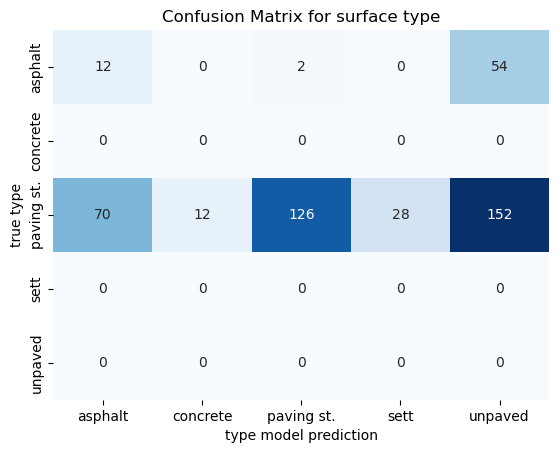

In [471]:
cm = confusion_matrix(merged.type_ground_truth, merged.type_pred_2048, labels=["asphalt", "concrete", "paving_stones", "sett", "unpaved"])
plt.figure()
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["asphalt", "concrete", "paving st.", "sett", "unpaved"],
            yticklabels=["asphalt", "concrete", "paving st.", "sett", "unpaved"])
plt.title(f"Confusion Matrix for surface type")
plt.xlabel("type model prediction")
plt.ylabel("true type")
plt.show()

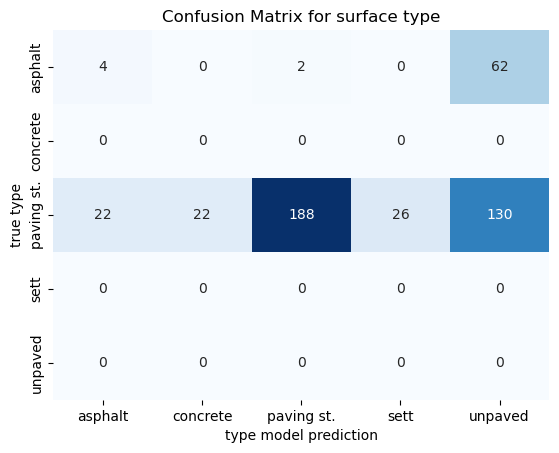

In [472]:
cm = confusion_matrix(merged.type_ground_truth, merged.type_pred_orig, labels=["asphalt", "concrete", "paving_stones", "sett", "unpaved"])
plt.figure()
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["asphalt", "concrete", "paving st.", "sett", "unpaved"],
            yticklabels=["asphalt", "concrete", "paving st.", "sett", "unpaved"])
plt.title(f"Confusion Matrix for surface type")
plt.xlabel("type model prediction")
plt.ylabel("true type")
plt.show()

In [473]:
(merged.type_ground_truth == merged.type_pred_2048).sum() / len(merged)

0.3026315789473684

In [474]:
(merged.type_ground_truth == merged.type_pred_orig).sum() / len(merged)

0.42105263157894735

-------

In [121]:
# # combine classification results
# orig = pd.read_csv("/Users/alexandra/Documents/GitHub/road_network_classification/data/weser_aue/run5/classification_results.csv")
# small = pd.read_csv("/Users/alexandra/Documents/GitHub/road_network_classification/data/weser_aue/run3/classification_results.csv")

# combined = pd.concat([orig, small])
# combined.drop_duplicates(subset=["img_id", "direction"], inplace=True, keep="first")
# combined.to_csv("/Users/alexandra/Documents/GitHub/road_network_classification/data/weser_aue/run6/classification_results_combined.csv", index=False)

### Analyze paving stones images

In [45]:
pv_blurr2 = pd.read_csv("/Users/alexandra/Documents/GitHub/road_network_classification/data/weser_aue/run11/classification_results.csv")

In [32]:
merged = (
    small.set_index(["img_id", "direction"])
    .join(blur2048.set_index(["img_id", "direction"]), lsuffix="", rsuffix="_blurr", how="inner")
    .join(pv_blurr2.set_index(["img_id", "direction"]), lsuffix="_2048", rsuffix="_blurr2", how="inner")
)
merged.reset_index(inplace=True)
merged = merged.set_index("img_id").join(link[["IMG_ID", "WAY_ID"]].set_index("IMG_ID"))
merged.reset_index(inplace=True)
merged = merged.set_index("WAY_ID").join(gt.set_index("ID"))

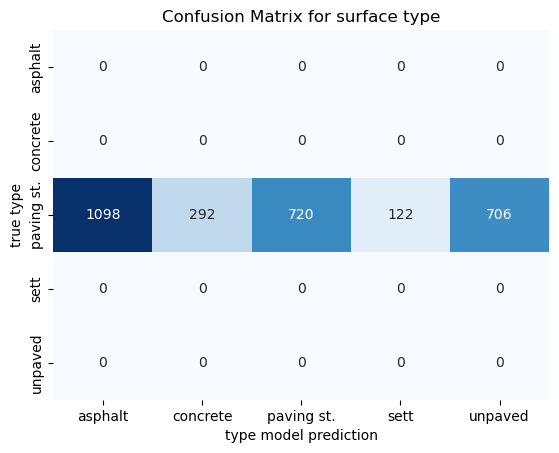

In [54]:
cm = confusion_matrix(merged.type_ground_truth, merged.type_pred_2048, labels=["asphalt", "concrete", "paving_stones", "sett", "unpaved"])
plt.figure()
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["asphalt", "concrete", "paving st.", "sett", "unpaved"],
            yticklabels=["asphalt", "concrete", "paving st.", "sett", "unpaved"])
plt.title(f"Confusion Matrix for surface type")
plt.xlabel("type model prediction")
plt.ylabel("true type")
plt.show()

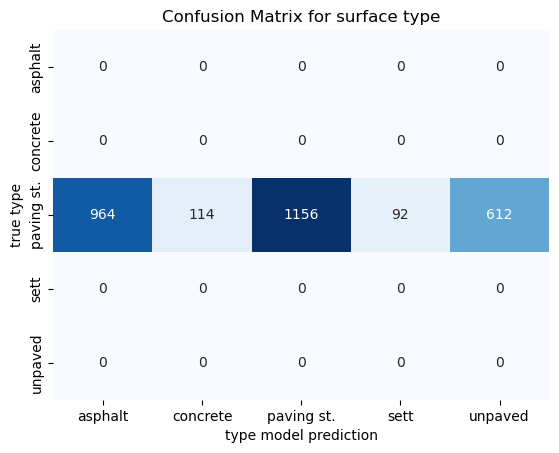

In [55]:
cm = confusion_matrix(merged.type_ground_truth, merged.type_pred_blurr, labels=["asphalt", "concrete", "paving_stones", "sett", "unpaved"])
plt.figure()
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["asphalt", "concrete", "paving st.", "sett", "unpaved"],
            yticklabels=["asphalt", "concrete", "paving st.", "sett", "unpaved"])
plt.title(f"Confusion Matrix for surface type")
plt.xlabel("type model prediction")
plt.ylabel("true type")
plt.show()

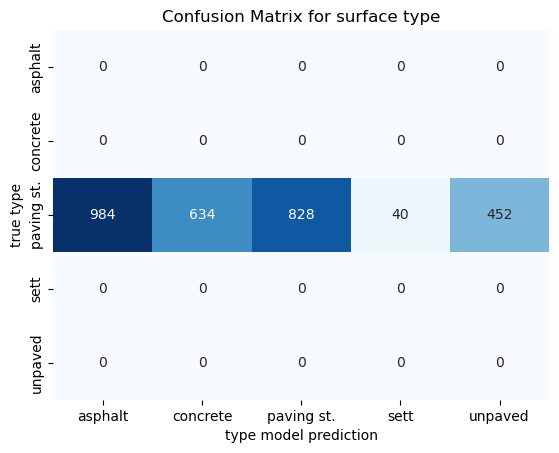

In [56]:
cm = confusion_matrix(merged.type_ground_truth, merged.type_pred_blurr2, labels=["asphalt", "concrete", "paving_stones", "sett", "unpaved"])
plt.figure()
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["asphalt", "concrete", "paving st.", "sett", "unpaved"],
            yticklabels=["asphalt", "concrete", "paving st.", "sett", "unpaved"])
plt.title(f"Confusion Matrix for surface type")
plt.xlabel("type model prediction")
plt.ylabel("true type")
plt.show()

------------------------------------

POINTWISE ANALYSIS

------------------------------------


## Global measures

In [5]:
def compute_measures_type(true, pred):
    return sum(true == pred) / len(true)

def compute_measures_quality(true_float, pred_float):
    m = {
    "accuracy": sum(true_float.round() == pred_float.round()) / len(true_float),
        "correlation": np.corrcoef(true_float, pred_float)[0, 1],
        "r_square": r2_score(true_float, pred_float),
        "mse": mean_squared_error(true_float, pred_float)
    }
    m["rmse"] = np.sqrt(m["mse"])
    return m

In [6]:
# all
gm = compute_measures_type(df.surface_clean, df.surface_pred)
gm

0.8047337278106509

## compare classes

In [7]:
class_name = "unpaved"
_df = df[df['surface_pred'] == class_name]
sum(_df.surface_clean == class_name) / len(_df)

0.7073170731707317

In [8]:
precision_score(df.surface_clean, df.surface_pred, average='weighted')

0.8236023791913214

In [9]:
recall_score(df.surface_clean, df.surface_pred, average='weighted')

/Users/alexandra/opt/anaconda3/envs/sai_dc/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


0.8047337278106509

In [10]:
# Extract predicted and ground truth values
for class_name in df['surface_clean'].unique():
    _df1 = df[df['surface_pred'] == class_name]
    _df2 = df[df['surface_clean'] == class_name]
    class_precision = sum(_df1.surface_clean == class_name) / len(_df1)
    class_recall = sum(_df2.surface_pred == class_name) / len(_df2)

    print(f"Class: {class_name}")
    print(f"Count (pred): {len(_df1)}")
    print(f"Count (true): {len(_df2)}")
    print(f"Precision: {round(class_precision, 2)}")
    print(f"Recall: {round(class_recall, 2)}")
    print("------------------------")


Class: asphalt
Count (pred): 256
Count (true): 230
Precision: 0.85
Recall: 0.94
------------------------
Class: paving_stones
Count (pred): 12
Count (true): 43
Precision: 0.92
Recall: 0.26
------------------------
Class: concrete
Count (pred): 24
Count (true): 24
Precision: 0.62
Recall: 0.62
------------------------
Class: unpaved
Count (pred): 41
Count (true): 41
Precision: 0.71
Recall: 0.71
------------------------


In [14]:
pv_img = pd.read_csv("../data/weser_aue/paving_stones_images.csv")

In [19]:
import shutil
os.makedirs("../data/weser_aue/paving_stones", exist_ok="OK")
for img in pv_img.img_id:
    # Construct the full file path
    for i  in [0, 1]:
        src_file_path = os.path.join("..", "data","weser_aue", "imgs_2048", f"{img}_{i}.jpg")
        dst_file_path = os.path.join("..", "data","weser_aue", "paving_stones", f"{img}_{i}.jpg")
    # Copy the file
    shutil.copy(src_file_path, dst_file_path)